# 🫀 Heart Disease Prediction and Interpretability

This notebook demonstrates a complete machine learning pipeline applied to the UCI Heart Disease dataset. All models and tools are implemented from scratch, including:

- Logistic Regression
- Decision Tree
- Random Forest
- LIME (Local Interpretable Model-Agnostic Explanations)

The goal is both predictive performance and interpretability — understanding **why** the model made a prediction.


## 🔧 Setup and Imports

We begin by importing all required modules from our custom `courselib` framework.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import shap

# Custom modules (all implemented from scratch)
from courselib.utils.loaders import load_heart_data
from courselib.utils.preprocessing import preprocess_dataframe
from courselib.utils.normalization import minmax_normalize
from courselib.utils.splits import train_test_split
from courselib.utils.metrics import mean_squared_error, binary_accuracy
from courselib.models.logistic import LogisticRegression
from courselib.models.tree import DecisionTree
from courselib.models.forest import RandomForest
from courselib.optimizers import GDOptimizer, MomentumOptimizer
from courselib.explain.lime import LimeTabularExplainer, run_lime_multiple_times, plot_lime_aggregated
from courselib.utils.summarization import summarize_after_preprocessing
from courselib.utils.cv import grid_search_cv
from courselib.utils.visualization import plot_confusion_matrix 

## 📥 Load and Preprocess Data

We use the UCI Heart Disease dataset, which includes patient data (e.g. age, sex, cholesterol, etc.) and a target variable indicating presence (1-4) or absence (0) of heart disease (Source: https://archive.ics.uci.edu/dataset/45/heart+disease). 

> ### 💡 Binary Transformation
>
> The target ranges from 0 to 4:
> - 0 = no presence of heart disease
> - 1–4 = presence of heart disease  
>  
> Our research focuses on the binary classification task: **presence (1–4) vs. absence (0)** as described in the dataset information.
> So we convert:
>
> $$
> y = \begin{cases}
>     0 & \text{if } y = 0 \\\\
>     1 & \text{if } y \in \{1, 2, 3, 4\}
> \end{cases}
> $$

Steps:
- Fetch dataset
- Convert multiclass to binary target
- Encode categorical features
- Normalize numerical features to [0, 1] range
- Split into training and testing sets


In [2]:
# Load raw data
X_df, y_series = load_heart_data()

# Convert target to binary: 0 (no disease), 1 (disease)
y_series = (y_series > 0).astype(int)

# Create a complete DataFrame with features and target
df_complete = pd.concat([X_df, y_series], axis=1)

# Combine and preprocess
X, y = preprocess_dataframe(df_complete, target_col= "num")

# Normalize features
X = minmax_normalize(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=42)

# Summarize the dataset after preprocessing
summarize_after_preprocessing(df_complete, X=X, X_train=X_train, X_test=X_test)


⚠️ Could not fetch Heart Disease dataset from UCI: Error connecting to server
📦 Falling back to local files: data/X_df.csv and data/y_series.csv
🧼 Dropping rows with missing values:
  - ca: 4 missing
  - thal: 2 missing
🧹 Total rows dropped: 6

📦 Train/test split:
  Training samples: 237
  Test samples:     60

🧾 Binary target distribution:
  Class 0: 164 samples (54.1%)
  Class 1: 139 samples (45.9%)

🔢 Feature matrix shape: 297 samples × 13 features


### Covariate Overview

This dataset contains 14 key attributes related to heart disease diagnosis. The primary covariates include:

- **age**: Patient age in years  
- **sex**: Gender (1 = male; 0 = female)  
- **cp**: Chest pain type (4 values)  
- **trestbps**: Resting blood pressure (in mm Hg)  
- **chol**: Serum cholesterol (in mg/dl)  
- **fbs**: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)  
- **restecg**: Resting ECG results (values 0–2)  
- **thalach**: Maximum heart rate achieved  
- **exang**: Exercise-induced angina (1 = yes; 0 = no)  
- **oldpeak**: ST depression induced by exercise  
- **slope**: Slope of the peak exercise ST segment  
- **ca**: Number of major vessels colored by fluoroscopy (0–3)  
- **thal**: Thalassemia (3 = normal; 6 = fixed defect; 7 = reversible defect)  
- **target**: Presence of heart disease (1 = yes; 0 = no)

_Source: [UCI Heart Disease Dataset](https://archive.ics.uci.edu/dataset/45/heart+disease)_


## 📈 Logistic Regression

We implement logistic regression using gradient descent.

> ### 💡 Model and Loss
>
> The model computes probabilities as:
>
> $$
> \hat{y}_i = \sigma(w^T x_i + b), \quad \text{where} \quad \sigma(z) = \frac{1}{1 + e^{-z}}
> $$
>
> The loss function is binary cross-entropy:
>
> $$
> \mathcal{L}(w, b) = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
> $$
>
> Optimized using gradient descent.


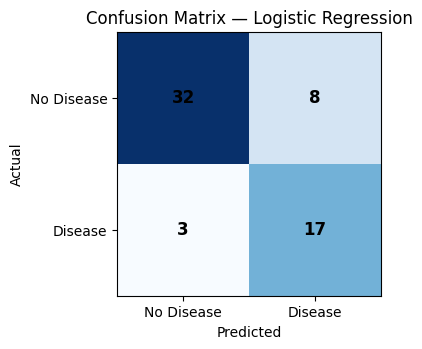

Logistic Regression Accuracy: 81.667%


In [3]:
optimizer = GDOptimizer(learning_rate=1e-3)
logreg = LogisticRegression(
    w=np.zeros(X_train.shape[1]), 
    b=0.0, 
    optimizer=optimizer, 
    penalty="none"
)

accuracy = lambda y_true,y_pred: binary_accuracy(y_true,y_pred,class_labels=[0,1])
metrics_dict = {'accuracy': accuracy,
                'MSE': mean_squared_error}
metrics_history = logreg.fit(X_train, y_train, num_epochs=150000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

y_pred_logreg = logreg(X_test)
plot_confusion_matrix(y_test, y_pred_logreg, model_name="Logistic Regression", save_path="assets/logreg_confusion_matrix.png")
print(f"Logistic Regression Accuracy: {accuracy(y_test, y_pred_logreg):.3f}%")

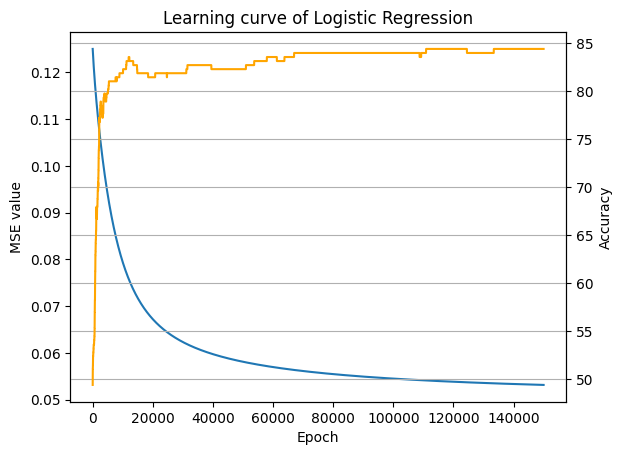

The final train accuracy: 84.388%
Test accuracy: 81.667%


In [4]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'])
ax.set_ylabel('MSE value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve of Logistic Regression')
plt.grid()
plt.show()

print(f'The final train accuracy: {metrics_history["accuracy"][-1]:.3f}%')
print(f'Test accuracy: {accuracy(logreg(X_test), y_test):.3f}%')

### 🧠 **Bonus: Accelerating Logistic Regression with Momentum**

Training deep or even shallow models using vanilla gradient descent can often be **slow to converge**, especially in the presence of noisy gradients or shallow slopes. One widely used remedy is **gradient descent with momentum**, which accumulates a velocity vector to smooth updates and speed up convergence.

By incorporating a `MomentumOptimizer` into our logistic regression setup, we aim to:

- Mitigate oscillations in flat or curved loss surfaces  
- Accelerate convergence to minima  
- Potentially reach better-performing solutions in fewer steps  

In the following, we swap out `GDOptimizer` for a `MomentumOptimizer` with `momentum=0.9` and track its effect on performance and convergence.


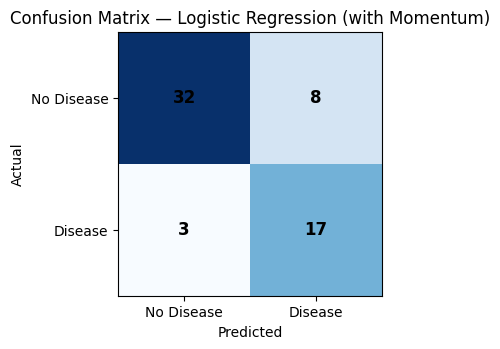

Logistic Regression Accuracy: 81.667%


In [5]:
optimizer = MomentumOptimizer(learning_rate=1e-3, momentum=0.9)

logreg_momentum = LogisticRegression(
    w=np.zeros(X_train.shape[1]), 
    b=0.0, 
    optimizer=optimizer, 
    penalty="none"
)

accuracy = lambda y_true,y_pred: binary_accuracy(y_true,y_pred,class_labels=[0,1])
metrics_dict = {'accuracy': accuracy,
                'MSE': mean_squared_error}
metrics_history_momentum = logreg_momentum.fit(X_train, y_train, num_epochs=25000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

y_pred_logreg_momentum = logreg_momentum(X_test)
plot_confusion_matrix(y_test, y_pred_logreg_momentum, model_name="Logistic Regression (with Momentum)", save_path="assets/logreg_momentum_confusion_matrix.png")
print(f"Logistic Regression Accuracy: {accuracy(y_test, y_pred_logreg_momentum):.3f}%")

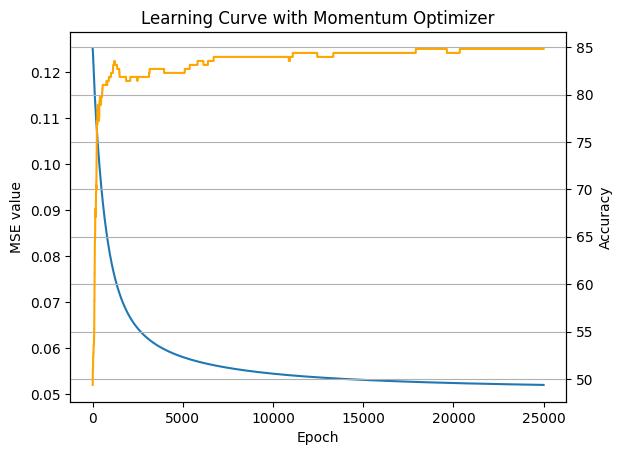

The final train accuracy: 84.810%
Test accuracy: 81.667%


In [6]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history_momentum['MSE'])), metrics_history_momentum['MSE'])
ax.set_ylabel('MSE value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history_momentum['accuracy'])), metrics_history_momentum['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning Curve with Momentum Optimizer')
plt.grid()
plt.show()

print(f'The final train accuracy: {metrics_history_momentum["accuracy"][-1]:.3f}%')
print(f'Test accuracy: {accuracy(logreg_momentum(X_test), y_test):.3f}%')

### 📊 **Result Summary: Momentum Accelerates Convergence**

The plots below clearly illustrate the benefit of adding momentum to gradient descent:

- The **standard GDOptimizer** required nearly **100,000 epochs** before the MSE stabilized around 0.053  
- In contrast, the **MomentumOptimizer converged in around 15,000 epochs**, reaching the same MSE value roughly **6× faster**
- Both models achieved a similar **final test accuracy of 81.67%**, but the momentum-based model got there significantly quicker and with smoother optimization

The confusion matrix further confirms the model’s reliability: most errors are false positives (8), with very few false negatives (3), suggesting a conservative tendency to avoid missing actual disease cases — a favorable tradeoff in clinical settings.

## 🌳 Decision Tree

Decision trees recursively split the data to reduce impurity and create interpretable decision rules.

> ### 💡 Impurity Measures
>
> Gini impurity:
>
> $$
> G = 1 - \sum_{k=1}^K p_k^2
> $$
>
> Entropy:
>
> $$
> H = -\sum_{k=1}^K p_k \log(p_k)
> $$
>
> A split is chosen to minimize weighted impurity across child nodes.

---

We tune the **`max_depth`** hyperparameter via **grid search** with **5-fold cross-validation**, optimizing for classification **accuracy**.

This helps prevent overfitting while selecting a performant, interpretable tree depth.


✅ Decision Tree (best CV depth = 3):
CV Accuracy: 75.931%


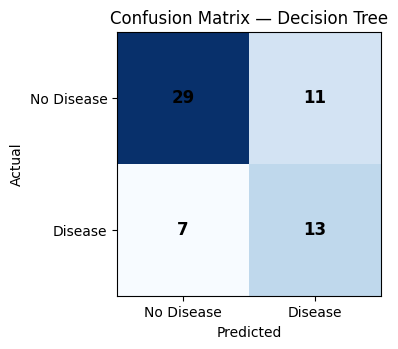

Test Accuracy: 70.000%


In [7]:
# Grid search for best tree depth using cross-validation
param_grid = {"max_depth": [2, 3, 4, 5, 6]}
best_tree, best_params, best_score = grid_search_cv(
    ModelClass=DecisionTree,
    param_grid=param_grid,
    X=X_train,
    y=y_train,
    metric_fn=accuracy,
    k=5,
    seed=42
)

# Evaluate best model on test set
y_pred_tree = best_tree.predict(X_test)
print(f"✅ Decision Tree (best CV depth = {best_params['max_depth']}):")
print(f"CV Accuracy: {best_score:.3f}%")
plot_confusion_matrix(y_test, y_pred_tree, model_name="Decision Tree", save_path="assets/decision_tree_confusion_matrix.png")
print(f"Test Accuracy: {accuracy(y_test, y_pred_tree):.3f}%")

## 🌲 Random Forest

Random forests are ensembles of decision trees, trained on random subsets of the data and features.

> ### 💡 Key Idea
>
> Combine multiple weak learners (trees) to create a strong learner.  
> Each tree votes, and the majority decision is the output.  
> This improves generalization and reduces variance.

---

We tune two key hyperparameters using **grid search** and **5-fold cross-validation**:

- `n_estimators`: the number of trees in the forest  
- `max_depth`: maximum depth allowed for each tree

We evaluate using **classification accuracy**.


✅ Best Random Forest Parameters: {'n_estimators': 45, 'max_depth': 3}
CV Accuracy: 80.585%


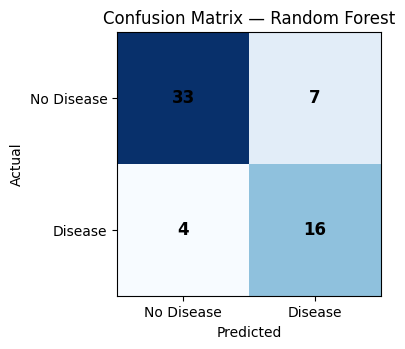

Test Accuracy: 81.667%


In [8]:
# Define parameter grid (reduced for runtime efficiency)
rf_param_grid = {
    "n_estimators": [5, 15, 45],
    "max_depth": [2, 3],
}

# Perform grid search
best_forest, best_rf_params, best_rf_score = grid_search_cv(
    ModelClass=RandomForest,
    param_grid=rf_param_grid,
    X=X_train,
    y=y_train,
    metric_fn=accuracy,
    k=5,
    seed=42,
    random_state=15
)

# Evaluate on test set
y_pred_forest = best_forest.predict(X_test)

print(f"✅ Best Random Forest Parameters: {best_rf_params}")
print(f"CV Accuracy: {best_rf_score:.3f}%")
plot_confusion_matrix(y_test, y_pred_forest, model_name="Random Forest", save_path="assets/random_forest_confusion_matrix.png")
print(f"Test Accuracy: {accuracy(y_test, y_pred_forest):.3f}%")

## 🚀 XGBoost Classifier

XGBoost is an efficient and scalable implementation of **gradient boosting**, a technique where models are built sequentially to correct the residuals of prior models.

> ### 💡 Boosting vs. Bagging
>
> Unlike random forests (which use **bagging**, training trees independently on resampled data), **boosting** combines weak learners in a sequential, additive manner:
>
> $$
> f(x) = \sum_{t=1}^T \eta \cdot h_t(x), \quad \text{where } h_t \text{ is a decision tree and } \eta \in (0, 1] \text{ as the learning rate}
> $$
>
> Each new tree $( h_t )$ is trained to predict the negative gradient of the loss function.

---

We use the official `xgboost.XGBClassifier` in combination with `GridSearchCV` and `make_scorer` for "state-of-the-art" performance, stability, and compatibility with SHAP.

To optimize predictive performance, we apply **grid search** with **5-fold cross-validation**, tuning:

- `n_estimators`: number of boosting rounds  
- `max_depth`: depth of individual trees  
- `learning_rate`: shrinkage factor applied to each boosting step

This model serves as a **performance benchmark** for comparison with simpler interpretable models.


✅ Best XGBoost Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50}


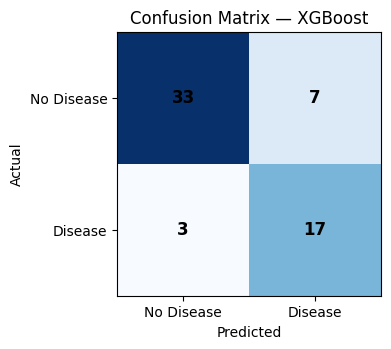

Test Accuracy (XGBoost): 83.333


In [9]:
# Use scikit-learn compatible wrapper
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)

# Grid of hyperparameters
xgb_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring=make_scorer(accuracy),
    cv=5,
    verbose=0
)

grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("✅ Best XGBoost Parameters:", grid.best_params_)
plot_confusion_matrix(y_test, y_pred_xgb, model_name="XGBoost", save_path="assets/xgboost_confusion_matrix.png")
print(f"Test Accuracy (XGBoost): {accuracy(y_test, y_pred_xgb):.3f}")

## 📊 Model Performance Comparison

We evaluate four classifiers trained and tuned on the same data:

- **Logistic Regression** (from scratch, using both plain GD and momentum)
- **Decision Tree** (from scratch, tuned via CV)
- **Random Forest** (from scratch, CV-tuned ensemble)
- **XGBoost** (external, tree-boosting library, grid search tuned)

> All models are evaluated on the same test set using accuracy.

---

The bar chart below summarizes the test accuracy of each model.  
This allows us to compare not just raw performance, but also the effects of ensembling, boosting, and optimization strategies.

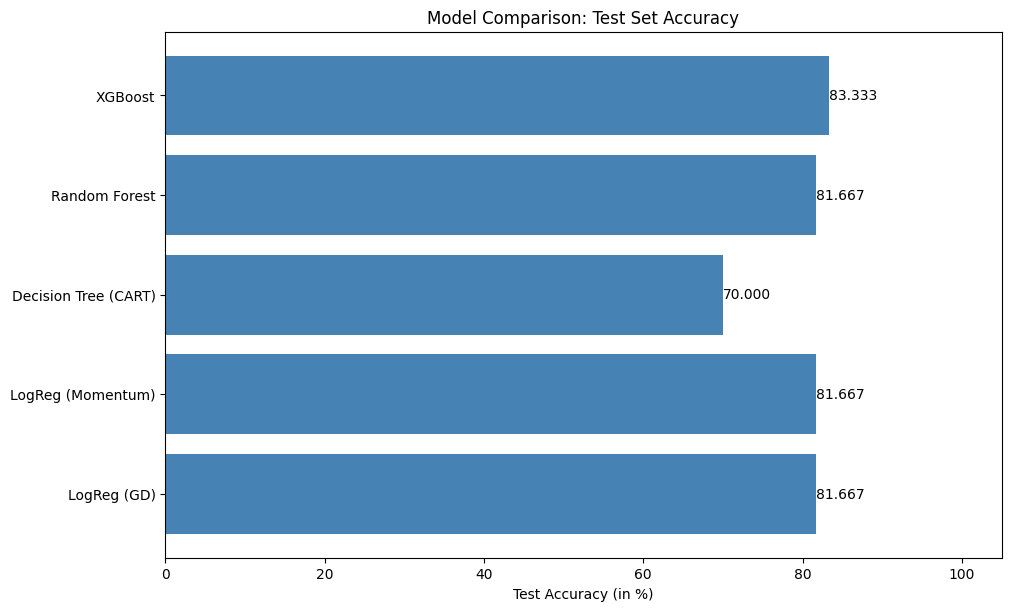

In [10]:
# Accuracy values (replace if rerun with updated results)
acc_logreg = accuracy(y_test, y_pred_logreg)
acc_logreg_momentum = accuracy(y_test, y_pred_logreg_momentum)
acc_tree = accuracy(y_test, y_pred_tree)
acc_forest = accuracy(y_test, y_pred_forest)
acc_xgb = accuracy(y_test, y_pred_xgb)

# Model names and scores
model_names = ["LogReg (GD)", "LogReg (Momentum)", "Decision Tree (CART)", "Random Forest", "XGBoost"]

test_accuracies = [acc_logreg, acc_logreg_momentum, acc_tree, acc_forest, acc_xgb]

# Plot
plt.figure(figsize=(10, 6), constrained_layout=True)
bars = plt.barh(model_names, test_accuracies, color="steelblue")
plt.xlabel("Test Accuracy (in %)")
plt.title("Model Comparison: Test Set Accuracy")

# Annotate bars with accuracy
for bar, acc in zip(bars, test_accuracies):
    plt.text(acc + 0.01, bar.get_y() + bar.get_height()/2, f"{acc:.3f}", va='center')

plt.xlim(0, 105)
plt.show()

### 📊 Summary: Model Comparison (Test Accuracy)

We evaluated five models on the same test set:

- **XGBoost** achieved the highest accuracy at **83.3%**
- **Random Forest** and both **Logistic Regression** variants (GD and Momentum) followed with **81.7%**
- The **Decision Tree (CART)** model had the lowest performance at **70.0%**

> Ensemble methods like Random Forest and XGBoost outperform standalone decision trees, demonstrating the benefits of bagging and boosting for stability and generalization.

Despite their simplicity, **Logistic Regression models** deliver competitive performance, reinforcing their role as strong, interpretable baselines in binary classification tasks.

## 🔍 LIME: Local Interpretable Model-Agnostic Explanations

We use LIME to explain predictions made by our tuned **Random Forest model (`best_forest`)** on individual instances.

LIME explains any black-box model by fitting a simple surrogate (e.g., linear regression) locally around the point of interest.

> ### 💡 Algorithm Overview
>
> 1. Generate perturbed samples $z_i$ around the target input $x_0$
> 2. Evaluate the Random Forest's prediction $f(z_i)$ for each
> 3. Compute locality-aware weights $\pi_{x_0}(z_i)$ based on distance
> 4. Fit a weighted linear model $g$ to approximate $f$ near $x_0$
> 5. Use the coefficients $\phi_i$ of $g$ as feature attributions

---

### 🎯 Optimization Objective

LIME solves the following local surrogate loss:

$$
\xi(x_0) = \arg\min_{g \in G} \sum_{i=1}^n \pi_{x_0}(z_i) \cdot (f(z_i) - g(z_i))^2 + \Omega(g)
$$

- $\pi_{x_0}(z_i)$ is an exponential kernel centered at $x_0$
- $\Omega(g)$ is a regularization term, here implemented via ridge regression
- The surrogate $g$ is an interpretable linear model fit to locally sampled data

---

We use our own `LimeTabularExplainer` and `RidgeRegression` to compute these attributions for a selected test instance. The `best_forest` model outputs binary predictions, which LIME approximates using local linear regression.

This approach provides insight into how individual features contribute to a specific decision made by the Random Forest model.


In [11]:
explainer = LimeTabularExplainer(X_train, feature_names=X_df.columns.tolist())
instance = X_test[15]
predict_fn = lambda x: best_forest(x)
weights, idx = explainer.explain_instance(instance, predict_fn, num_samples=1250)

print("Top LIME Features:")
for feat, w in explainer.as_list(weights, idx, top_k=7):
    print(f"{feat}: {w:.4f}")

Top LIME Features:
thal: 0.0418
exang: 0.0303
fbs: -0.0155
cp: 0.0137
trestbps: 0.0133
sex: -0.0128
age: 0.0124


## 📊 LIME Stability: Comparing Explanations Across Models

LIME uses local perturbations to explain individual model predictions — but its output can vary due to randomness in sampling. To address this, we apply LIME **multiple times** and aggregate the results.

> ### 💡 Why Aggregate?
>
> Running LIME repeatedly helps identify which features are **consistently important** and which fluctuate due to sampling noise.  
> This improves the reliability of explanations and enables fair comparison between models.

---

We explain a **single test instance** using both:

- **Random Forest (`best_forest`)**
- **XGBoost (`best_xgb`)**

For each model, we run LIME **50 times**, generating **1250 perturbations** per run. This configuration strikes a balance between:

- Sufficient **perturbation diversity** within each run
- Meaningful **variability assessment** across runs
- Reasonable **computational cost**

We then compute the **mean ± standard deviation** of the learned feature weights.  
The resulting bar plots highlight the **top 7 features** by average importance, and allow us to compare how each model reasons about the same prediction — with uncertainty visualized explicitly.

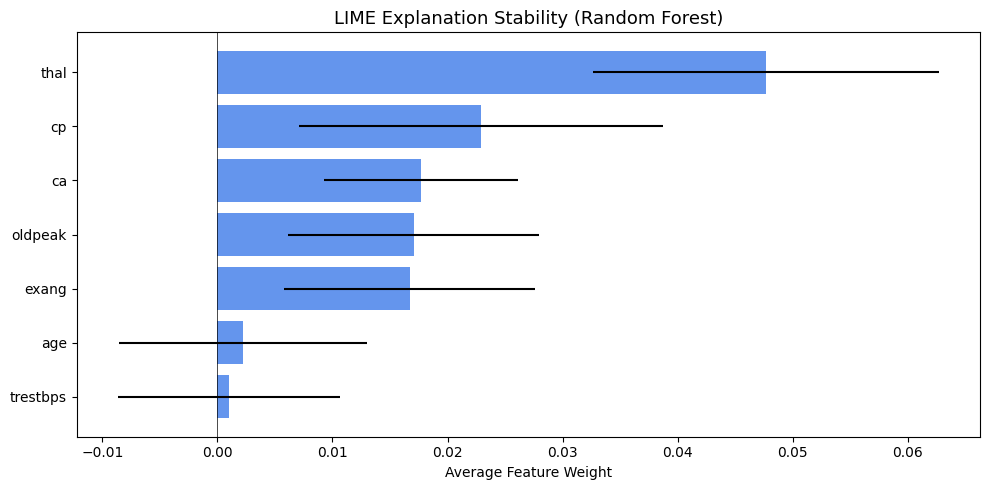

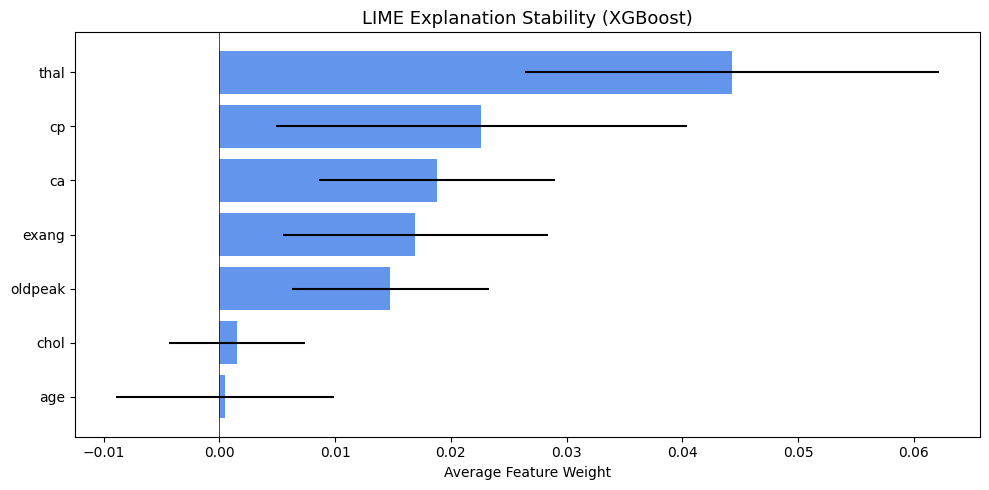

In [12]:
# Select instance and features
instance_idx = 15
instance = X_test[instance_idx]
feature_names = X_df.columns.tolist()

# Define prediction function (example: XGBoost class 1 prob)
predict_fn_random_forest = lambda x: best_forest(x)
predict_fn_xgboost = lambda x: best_xgb.predict_proba(np.atleast_2d(x))[:, 1]

# Initialize explainer
explainer = LimeTabularExplainer(X_train, feature_names=feature_names)

# --------------------------------------------------
# Run LIME for Random Forest
means, stds, top_feats = run_lime_multiple_times(explainer=explainer, instance=instance, model_predict_fn=predict_fn_random_forest, 
                                                 feature_names=feature_names, n_runs=50, num_samples=1250, top_k=7)

# Plot results
plot_lime_aggregated(top_means=means, top_stds=stds, top_features=top_feats, title="LIME Explanation Stability (Random Forest)")

# --------------------------------------------------
# Run LIME for XGBoost
means, stds, top_feats = run_lime_multiple_times(explainer=explainer, instance=instance, model_predict_fn=predict_fn, 
                                                 feature_names=feature_names, n_runs=50, num_samples=1250, top_k=7)

# Plot results
plot_lime_aggregated(top_means=means, top_stds=stds, top_features=top_feats, title="LIME Explanation Stability (XGBoost)")

In [13]:
# Alternative: Increase the number of samples in a single run for more stable results being comparable to the multiple runs
weights_increased_sample, idx_increased_sample = explainer.explain_instance(instance, predict_fn, num_samples=25000)

print("Top LIME Features:")
for feat, w in explainer.as_list(weights_increased_sample, idx_increased_sample, top_k=7):
    print(f"{feat}: {w:.4f}")

Top LIME Features:
thal: 0.4480
cp: 0.2550
oldpeak: 0.2520
ca: 0.2169
thalach: -0.1138
exang: 0.1027
restecg: 0.0518


## 🧠 SHAP Explanations for Tree Models

Unlike LIME, which fits local surrogate models using sampling, **SHAP computes exact feature attributions** based on Shapley values from game theory.  
This makes SHAP **more theoretically grounded and consistent**, especially for tree-based models.

> We use `TreeExplainer`, optimized for models like XGBoost, to compute SHAP values efficiently.

---

### 💡 Mathematical Foundation

Each prediction $f(x)$ is decomposed into:

$$
f(x) = \phi_0 + \sum_{i=1}^M \phi_i
$$

- $\phi_0$: the base value (mean prediction)
- $\phi_i$: the **Shapley value** — contribution of feature $i$ averaged over all feature subsets

These values ensure:

- **Local accuracy**: decomposition matches the model output  
- **Consistency**: increasing a feature's importance never lowers $\phi_i$  
- **Missingness**: features not used have zero contribution

---

### Our application:

We apply SHAP to our trained **XGBoost classifier** `best_xgb`:

- A **global bar plot** ranks features by average absolute contribution across the test set  
- A **local waterfall plot** explains the contribution of each feature for a single prediction (instance #15)

This allows both global and instance-level interpretation of the model’s behavior.


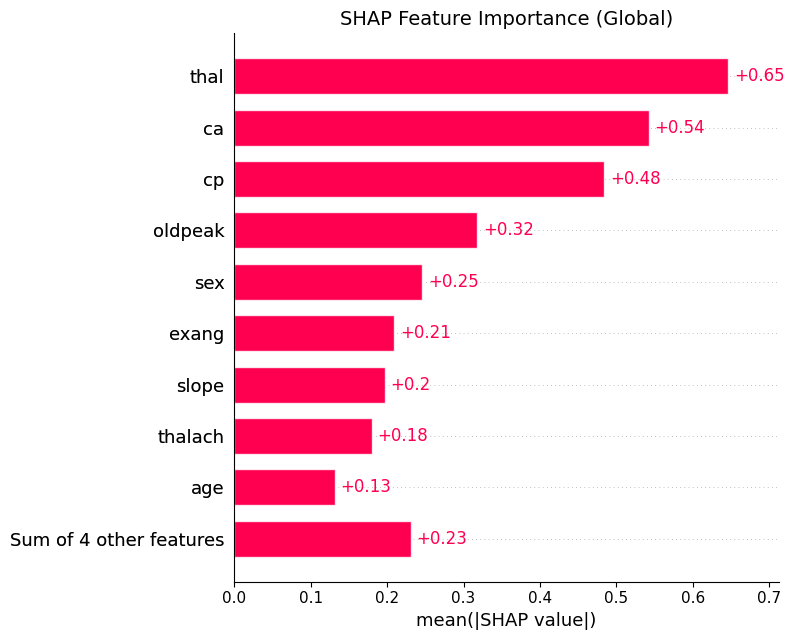

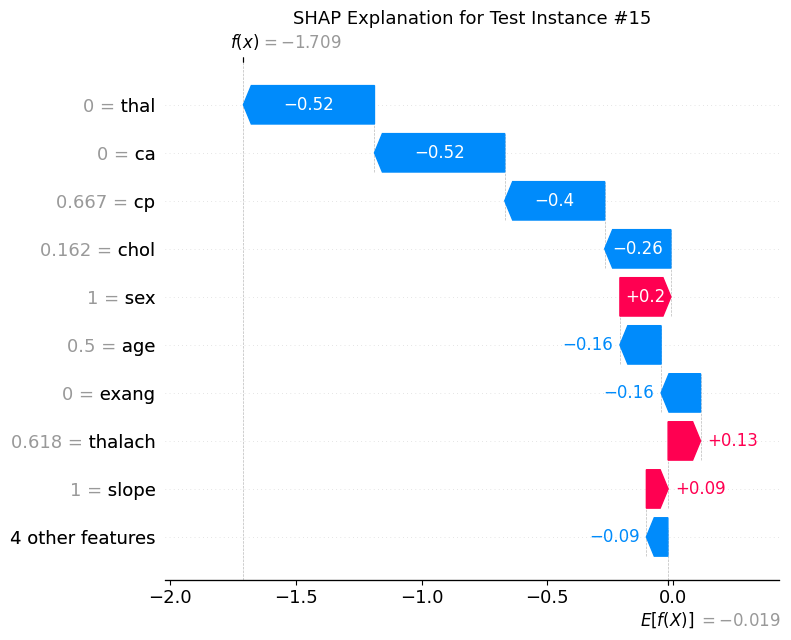

In [15]:
# Ensure DataFrame with feature names
feature_names = X_df.columns.tolist()
X_test_named = pd.DataFrame(X_test, columns=feature_names)

# Use Tree Explainer for XGBoost
explainer = shap.TreeExplainer(best_xgb, feature_names=feature_names)
shap_values = explainer(X_test_named)

# -------- Global Bar Plot (Top features) --------
plt.figure(figsize=(8, 6))
shap.plots.bar(shap_values, max_display=10, show=False)
plt.title("SHAP Feature Importance (Global)", fontsize=14)
plt.tight_layout()
plt.savefig("assets/shap_global_bar.png")  # Save the plot to assets folder
plt.show()


# -------- Local Waterfall Plot --------
instance_idx = 15
plt.figure(figsize=(9, 5))
shap.plots.waterfall(shap_values[instance_idx], show=False)
plt.title(f"SHAP Explanation for Test Instance #{instance_idx}", fontsize=13)
plt.tight_layout()
plt.savefig("assets/shap_waterfall_instance_15.png")
plt.show()

## 🧠 SHAP Results Summary

The SHAP analysis provides both global and local explanations of how the XGBoost model predicts heart disease.

---

### 🔍 Global Importance

The bar plot shows the **average absolute SHAP value** of each feature across the test set. Key findings:

- `thal` (thalassemia), `ca` (number of vessels), and `cp` (chest pain type) have the highest contributions
- These features are clinically meaningful and consistently influential across patients

---

### 📍 Local Explanation for Test Instance #15

The waterfall plot visualizes the prediction breakdown for one patient:

- **Negative SHAP values** from `thal`, `ca`, and `sex` strongly reduce the predicted risk
- **Positive contributions** from `cp`, `slope`, and `thalach` moderately increase it
- The final prediction is **below the average**, indicating low predicted risk

---

### 🔄 Comparison to LIME

The aggregated LIME results for the same instance (with 50×1250 perturbations) largely **agree with SHAP** on the top features:

- Both methods highlight `cp`, `thal`, and `ca` as the most important
- Rankings differ slightly: LIME ranks `cp` highest, while SHAP gives more weight to `thal`
- The aggregated LIME offers uncertainty (via error bars), while SHAP gives exact local attributions

> Together, these results reinforce the model’s reliance on core cardiovascular features and demonstrate **interpretability consistency** across explanation methods.

## ✅ Final Summary

This project covered the full modeling and interpretability pipeline for binary heart disease prediction:

---

### 🔧 Models Implemented from Scratch

- 🧮 **Logistic Regression** — trained with both standard GD and momentum
- 🌳 **Decision Tree (CART)** — using recursive splits and impurity measures
- 🌲 **Random Forest** — an ensemble of decision trees with randomized subsets
- 🚀 **XGBoost** — benchmark gradient boosting model using optimized xgboost and sklearn package

Despite being implemented manually, the models reached competitive performance, with **XGBoost achieving the highest test accuracy (83.3%)**, followed closely by **Random Forest and both Logistic Regression variants (81.7%)**.

---

### 🔍 Interpretability Methods Applied

- **LIME** was used to locally approximate model decisions and assess attribution stability through repeated sampling
- **SHAP** provided additive, consistent feature attributions with exact breakdowns for tree models (XGBoost)

Both methods consistently identified the following clinical features as most influential:

- `thal`: Thalassemia (blood disorder)
- `cp`: Chest pain type
- `ca`: Number of major vessels colored by fluoroscopy

---

### 📈 Conclusion

This project demonstrates how core machine learning models and interpretability tools can be:
- Implemented from scratch
- Tuned and compared fairly
- Made transparent through local and global explanation techniques

> The results confirm that interpretable models can be both accurate and trustworthy — a critical consideration in sensitive domains like healthcare.